# Context Cost Analysis with Statistical Evaluation (P-1 to P-6)

This notebook performs a comprehensive cost analysis of six context variations (P-1 through P-6) with statistical evaluation and publication-ready outputs.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway, kruskal, tukey_hsd, ttest_ind
from scikit_posthocs import posthoc_dunn
import glob
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Create output directory
output_dir = Path('.')
output_dir.mkdir(exist_ok=True)

## Step 1: Data Loading

In [2]:
# Define paths
generation_path = "../generation/datasets/"

# Find all prompt variation CSV files (P-1 to P-6)
prompt_files = []
for i in range(1, 7):
    file_path = os.path.join(generation_path, f"prompt_variation_P-{i}_generated.csv")
    if os.path.exists(file_path):
        prompt_files.append(file_path)
    else:
        print(f"Warning: {file_path} not found")

print(f"Found {len(prompt_files)} prompt variation files:")
for file in prompt_files:
    print(f"  {os.path.basename(file)}")

Found 6 prompt variation files:
  prompt_variation_P-1_generated.csv
  prompt_variation_P-2_generated.csv
  prompt_variation_P-3_generated.csv
  prompt_variation_P-4_generated.csv
  prompt_variation_P-5_generated.csv
  prompt_variation_P-6_generated.csv


In [3]:
# Load and combine all data
all_data = []

for file_path in prompt_files:
    print(f"Loading {os.path.basename(file_path)}...")
    df = pd.read_csv(file_path)
    
    # Extract variation name from filename
    variation = os.path.basename(file_path).split('_')[2]  # P-1, P-2, etc.
    df['variation'] = variation
    
    # Select relevant columns
    columns_needed = ['id', 'prompt_variation', 'total_input_tokens', 'total_output_tokens', 
                      'total_tokens', 'generated_description', 'variation']
    
    # Check if all columns exist
    missing_cols = [col for col in columns_needed if col not in df.columns]
    if missing_cols:
        print(f"  Warning: Missing columns in {os.path.basename(file_path)}: {missing_cols}")
        # Use available columns
        available_cols = [col for col in columns_needed if col in df.columns]
        df_subset = df[available_cols].copy()
    else:
        df_subset = df[columns_needed].copy()
    
    # Rename token columns for consistency
    df_subset = df_subset.rename(columns={
        'total_input_tokens': 'prompt_tokens',
        'total_output_tokens': 'completion_tokens'
    })
    
    all_data.append(df_subset)
    print(f"  Loaded {len(df_subset)} records")

# Combine all data
combined_data = pd.concat(all_data, ignore_index=True)
print(f"\nTotal combined data: {len(combined_data)} records")
print(f"Columns: {combined_data.columns.tolist()}")

Loading prompt_variation_P-1_generated.csv...
  Loaded 240 records
Loading prompt_variation_P-2_generated.csv...
  Loaded 240 records
Loading prompt_variation_P-3_generated.csv...
  Loaded 240 records
Loading prompt_variation_P-4_generated.csv...
  Loaded 240 records
Loading prompt_variation_P-5_generated.csv...
  Loaded 240 records
Loading prompt_variation_P-6_generated.csv...
  Loaded 240 records

Total combined data: 1440 records
Columns: ['id', 'prompt_variation', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'generated_description', 'variation']


In [4]:
# Data cleaning and preparation
print("Data cleaning...")

# Remove any rows with missing token data
initial_count = len(combined_data)
combined_data = combined_data.dropna(subset=['prompt_tokens', 'completion_tokens', 'total_tokens'])
print(f"Removed {initial_count - len(combined_data)} rows with missing token data")

# Ensure token columns are numeric
for col in ['prompt_tokens', 'completion_tokens', 'total_tokens']:
    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')

# Remove any remaining NaN values
combined_data = combined_data.dropna(subset=['prompt_tokens', 'completion_tokens', 'total_tokens'])

# Calculate word and sentence counts from generated descriptions
if 'generated_description' in combined_data.columns:
    combined_data['word_count'] = combined_data['generated_description'].fillna('').apply(
        lambda x: len(str(x).split())
    )
    combined_data['sentence_count'] = combined_data['generated_description'].fillna('').apply(
        lambda x: len([s for s in str(x).split('.') if s.strip()])
    )
else:
    print("Warning: 'generated_description' column not found. Setting word_count and sentence_count to 1.")
    combined_data['word_count'] = 1
    combined_data['sentence_count'] = 1

# Use 'id' as pr_id if available, otherwise create index
if 'id' in combined_data.columns:
    combined_data['pr_id'] = combined_data['id']
else:
    combined_data['pr_id'] = combined_data.index

print(f"Final dataset: {len(combined_data)} records")
print(f"Variations: {sorted(combined_data['variation'].unique())}")

Data cleaning...
Removed 0 rows with missing token data
Final dataset: 1440 records
Variations: ['P-1', 'P-2', 'P-3', 'P-4', 'P-5', 'P-6']


In [5]:
# Display basic info about the dataset
print("Dataset overview:")
print(combined_data.groupby('variation').size())
print("\nSample data:")
display(combined_data[['pr_id', 'variation', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'word_count', 'sentence_count']].head())

Dataset overview:
variation
P-1    240
P-2    240
P-3    240
P-4    240
P-5    240
P-6    240
dtype: int64

Sample data:


,pr_id,variation,prompt_tokens,completion_tokens,total_tokens,word_count,sentence_count
0,PR_kwDOAQ0TF85oN6RH,P-1,99,25,124,15,2
1,MDExOlB1bGxSZXF1ZXN0NTcwMzYyODc2,P-1,526,129,655,50,5
2,MDExOlB1bGxSZXF1ZXN0NTcwMzYyODc2,P-1,526,129,655,50,5
3,MDExOlB1bGxSZXF1ZXN0NTcwMzYyODc2,P-1,526,129,655,50,5
4,MDExOlB1bGxSZXF1ZXN0NTcwMzYyODc2,P-1,526,129,655,50,5


## Step 2: Descriptive Statistics

In [5]:
# Calculate descriptive statistics for each variation
def calculate_descriptive_stats(df):
    stats_list = []
    
    for variation in sorted(df['variation'].unique()):
        var_data = df[df['variation'] == variation]
        
        # Basic token statistics
        prompt_stats = var_data['prompt_tokens'].describe()
        completion_stats = var_data['completion_tokens'].describe()
        total_stats = var_data['total_tokens'].describe()
        
        # Calculate ratios and efficiency metrics
        # Avoid division by zero
        prompt_completion_ratio = (var_data['prompt_tokens'] / 
                                 var_data['completion_tokens'].replace(0, np.nan)).mean()
        efficiency_score = (var_data['completion_tokens'] / 
                          var_data['total_tokens'].replace(0, np.nan)).mean()
        
        # Normalized costs
        tokens_per_word = (var_data['total_tokens'] / 
                          var_data['word_count'].replace(0, np.nan)).mean()
        tokens_per_sentence = (var_data['total_tokens'] / 
                              var_data['sentence_count'].replace(0, np.nan)).mean()
        
        stats_dict = {
            'Variation': variation,
            'Count': len(var_data),
            'Mean_Prompt_Tokens': prompt_stats['mean'],
            'Median_Prompt_Tokens': prompt_stats['50%'],
            'Min_Prompt_Tokens': prompt_stats['min'],
            'Max_Prompt_Tokens': prompt_stats['max'],
            'Std_Prompt_Tokens': prompt_stats['std'],
            'Mean_Completion_Tokens': completion_stats['mean'],
            'Median_Completion_Tokens': completion_stats['50%'],
            'Min_Completion_Tokens': completion_stats['min'],
            'Max_Completion_Tokens': completion_stats['max'],
            'Std_Completion_Tokens': completion_stats['std'],
            'Mean_Total_Tokens': total_stats['mean'],
            'Median_Total_Tokens': total_stats['50%'],
            'Min_Total_Tokens': total_stats['min'],
            'Max_Total_Tokens': total_stats['max'],
            'Std_Total_Tokens': total_stats['std'],
            'Prompt_Completion_Ratio': prompt_completion_ratio,
            'Efficiency_Score': efficiency_score,
            'Tokens_Per_Word': tokens_per_word,
            'Tokens_Per_Sentence': tokens_per_sentence
        }
        
        stats_list.append(stats_dict)
    
    return pd.DataFrame(stats_list)

# Calculate statistics
descriptive_stats = calculate_descriptive_stats(combined_data)
display(descriptive_stats.round(2))

# Save to CSV
descriptive_stats.to_csv('context_cost_analysis_results.csv', index=False)
print("\nSaved descriptive statistics to 'context_cost_analysis_results.csv'")

,Variation,Count,Mean_Prompt_Tokens,Median_Prompt_Tokens,Min_Prompt_Tokens,Max_Prompt_Tokens,Std_Prompt_Tokens,Mean_Completion_Tokens,Median_Completion_Tokens,Min_Completion_Tokens,...,Std_Completion_Tokens,Mean_Total_Tokens,Median_Total_Tokens,Min_Total_Tokens,Max_Total_Tokens,Std_Total_Tokens,Prompt_Completion_Ratio,Efficiency_Score,Tokens_Per_Word,Tokens_Per_Sentence
0,P-1,240,1568.71,1035.0,99.0,3778.0,1305.75,331.06,261.0,15.0,...,252.82,1899.77,1281.0,119.0,4529.0,1557.17,4.80,0.18,17.09,244.60
1,P-2,240,4790.77,3461.0,495.0,11477.0,3930.32,599.88,508.0,28.0,...,448.42,5390.65,3860.0,533.0,12802.0,4374.63,8.28,0.11,31.26,489.20
2,P-3,240,4908.58,3646.0,508.0,11648.0,3981.80,636.12,539.0,23.0,...,462.43,5544.70,4200.0,539.0,13018.0,4439.28,7.94,0.12,34.68,621.24
3,P-4,240,24989.92,11091.0,628.0,72745.0,27368.88,806.11,616.0,40.0,...,635.29,25796.03,11668.0,670.0,74588.0,27990.64,24.82,0.05,108.39,3855.95
4,P-5,240,139352.44,96492.0,1116.0,504021.0,133835.66,866.39,630.0,51.0,...,699.96,140218.83,97408.0,1179.0,504637.0,134331.77,169.82,0.01,610.40,12313.87
5,P-6,240,143756.08,97368.0,1252.0,504743.0,137253.74,823.68,644.0,60.0,...,620.98,144579.75,98292.0,1325.0,505317.0,137697.70,178.42,0.01,741.38,15434.77



Saved descriptive statistics to 'context_cost_analysis_results.csv'


## Step 3: Impact & Rankings

In [6]:
# Calculate relative costs with P-1 as baseline
baseline_variation = 'P-1'
baseline_cost = descriptive_stats[descriptive_stats['Variation'] == baseline_variation]['Mean_Total_Tokens'].iloc[0]

# Calculate relative costs
ranking_data = []
for _, row in descriptive_stats.iterrows():
    variation = row['Variation']
    mean_tokens = row['Mean_Total_Tokens']
    
    if variation == baseline_variation:
        pct_diff = 0.0
    else:
        pct_diff = ((mean_tokens - baseline_cost) / baseline_cost) * 100
    
    ranking_data.append({
        'Variation': variation,
        'Mean_Total_Tokens': mean_tokens,
        'Percent_Difference_vs_P1': pct_diff
    })

ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Mean_Total_Tokens')
ranking_df['Ranking'] = range(1, len(ranking_df) + 1)

print(f"Cost ranking (baseline = {baseline_variation}):")
display(ranking_df.round(2))

# Save to CSV
ranking_df.to_csv('context_cost_ranking.csv', index=False)
print("\nSaved ranking to 'context_cost_ranking.csv'")

Cost ranking (baseline = P-1):


,Variation,Mean_Total_Tokens,Percent_Difference_vs_P1,Ranking
0,P-1,1899.77,0.00,1
1,P-2,5390.65,183.75,2
2,P-3,5544.70,191.86,3
3,P-4,25796.03,1257.85,4
4,P-5,140218.83,7280.83,5
5,P-6,144579.75,7510.38,6



Saved ranking to 'context_cost_ranking.csv'


## Step 4: Statistical Testing

In [7]:
# Prepare data for statistical testing
variations = sorted(combined_data['variation'].unique())
token_data_by_variation = []

for variation in variations:
    var_tokens = combined_data[combined_data['variation'] == variation]['total_tokens'].values
    token_data_by_variation.append(var_tokens)
    
print(f"Variations for statistical testing: {variations}")
print(f"Sample sizes: {[len(data) for data in token_data_by_variation]}")

Variations for statistical testing: ['P-1', 'P-2', 'P-3', 'P-4', 'P-5', 'P-6']
Sample sizes: [240, 240, 240, 240, 240, 240]


In [8]:
# Test for normality (Shapiro-Wilk test)
print("Testing for normality (Shapiro-Wilk test):")
normality_results = []
all_normal = True

for i, (variation, data) in enumerate(zip(variations, token_data_by_variation)):
    # Use a sample if data is too large for Shapiro-Wilk
    if len(data) > 5000:
        sample_data = np.random.choice(data, 5000, replace=False)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    is_normal = p_value > 0.05
    
    normality_results.append({
        'Variation': variation,
        'Shapiro_Stat': stat,
        'Shapiro_P_Value': p_value,
        'Is_Normal': is_normal
    })
    
    if not is_normal:
        all_normal = False
    
    print(f"{variation}: W={stat:.4f}, p={p_value:.6f}, Normal: {is_normal}")

print(f"\nAll distributions normal: {all_normal}")

Testing for normality (Shapiro-Wilk test):
P-1: W=0.8146, p=0.000000, Normal: False
P-2: W=0.8093, p=0.000000, Normal: False
P-3: W=0.8163, p=0.000000, Normal: False
P-4: W=0.7349, p=0.000000, Normal: False
P-5: W=0.8092, p=0.000000, Normal: False
P-6: W=0.8117, p=0.000000, Normal: False

All distributions normal: False


In [9]:
# Perform ANOVA or Kruskal-Wallis test
if all_normal:
    print("\nPerforming one-way ANOVA...")
    f_stat, anova_p = f_oneway(*token_data_by_variation)
    test_used = "One-way ANOVA"
    test_stat = f_stat
    
    # Calculate eta-squared (effect size)
    ss_between = sum([len(data) * (np.mean(data) - np.mean(np.concatenate(token_data_by_variation)))**2 
                     for data in token_data_by_variation])
    ss_total = sum([(x - np.mean(np.concatenate(token_data_by_variation)))**2 
                   for data in token_data_by_variation for x in data])
    eta_squared = ss_between / ss_total
    
else:
    print("\nPerforming Kruskal-Wallis test...")
    h_stat, anova_p = kruskal(*token_data_by_variation)
    test_used = "Kruskal-Wallis"
    test_stat = h_stat
    
    # Calculate eta-squared approximation for Kruskal-Wallis
    total_n = sum([len(data) for data in token_data_by_variation])
    eta_squared = (h_stat - len(variations) + 1) / (total_n - len(variations))

print(f"Test: {test_used}")
print(f"Test statistic: {test_stat:.4f}")
print(f"P-value: {anova_p:.6f}")
print(f"Significant (p<0.05): {anova_p < 0.05}")
print(f"Effect size (η²): {eta_squared:.4f}")

# Interpret effect size
if eta_squared < 0.01:
    effect_interpretation = "Very small"
elif eta_squared < 0.06:
    effect_interpretation = "Small"
elif eta_squared < 0.14:
    effect_interpretation = "Medium"
else:
    effect_interpretation = "Large"

print(f"Effect size interpretation: {effect_interpretation}")


Performing Kruskal-Wallis test...
Test: Kruskal-Wallis
Test statistic: 956.4520
P-value: 0.000000
Significant (p<0.05): True
Effect size (η²): 0.6635
Effect size interpretation: Large


In [10]:
# Post-hoc testing if significant differences found
posthoc_results = []
pairwise_results = []

if anova_p < 0.05:
    print("\nSignificant differences found. Performing post-hoc tests...")
    
    if all_normal:
        print("\nTukey's HSD test:")
        # Prepare data for Tukey's test
        tukey_data = []
        tukey_groups = []
        
        for i, (variation, data) in enumerate(zip(variations, token_data_by_variation)):
            tukey_data.extend(data)
            tukey_groups.extend([variation] * len(data))
        
        try:
            tukey_result = tukey_hsd(tukey_data, tukey_groups)
            print(tukey_result)
            
            # Extract pairwise comparisons
            for i in range(len(variations)):
                for j in range(i+1, len(variations)):
                    var1, var2 = variations[i], variations[j]
                    # Find corresponding p-value from tukey result
                    try:
                        p_val = tukey_result.pvalue[i, j] if hasattr(tukey_result, 'pvalue') else np.nan
                    except:
                        p_val = np.nan
                    
                    posthoc_results.append({
                        'Comparison': f"{var1} vs {var2}",
                        'Test': "Tukey HSD",
                        'P_Value': p_val,
                        'Significant': p_val < 0.05 if not np.isnan(p_val) else False
                    })
        except Exception as e:
            print(f"Error in Tukey's test: {e}")
            print("Falling back to pairwise t-tests")
    
    else:
        print("\nDunn's test (post-hoc for Kruskal-Wallis):")
        try:
            # Prepare data for Dunn's test
            dunn_data = pd.DataFrame({
                'values': np.concatenate(token_data_by_variation),
                'groups': np.concatenate([[var]*len(data) for var, data in zip(variations, token_data_by_variation)])
            })
            
            dunn_result = posthoc_dunn(dunn_data, val_col='values', group_col='groups', p_adjust='bonferroni')
            print(dunn_result)
            
            # Extract pairwise comparisons
            for i in range(len(variations)):
                for j in range(i+1, len(variations)):
                    var1, var2 = variations[i], variations[j]
                    try:
                        p_val = dunn_result.loc[var1, var2]
                    except:
                        p_val = np.nan
                    
                    posthoc_results.append({
                        'Comparison': f"{var1} vs {var2}",
                        'Test': "Dunn",
                        'P_Value': p_val,
                        'Significant': p_val < 0.05 if not np.isnan(p_val) else False
                    })
        except Exception as e:
            print(f"Error in Dunn's test: {e}")
            print("Falling back to pairwise tests")

else:
    print("\nNo significant differences found. Skipping post-hoc tests.")


Significant differences found. Performing post-hoc tests...

Dunn's test (post-hoc for Kruskal-Wallis):
               P-1           P-2           P-3           P-4            P-5  \
P-1   1.000000e+00  2.436979e-08  4.186095e-10  7.741231e-40  2.258203e-118   
P-2   2.436979e-08  1.000000e+00  1.000000e+00  2.369568e-12   3.017004e-65   
P-3   4.186095e-10  1.000000e+00  1.000000e+00  2.149383e-10   1.227500e-60   
P-4   7.741231e-40  2.369568e-12  2.149383e-10  1.000000e+00   1.183836e-21   
P-5  2.258203e-118  3.017004e-65  1.227500e-60  1.183836e-21   1.000000e+00   
P-6  3.719929e-125  2.656547e-70  1.632542e-65  1.336590e-24   1.000000e+00   

               P-6  
P-1  3.719929e-125  
P-2   2.656547e-70  
P-3   1.632542e-65  
P-4   1.336590e-24  
P-5   1.000000e+00  
P-6   1.000000e+00  


In [11]:
# Pairwise t-tests with Welch's correction
print("\nPairwise t-tests (Welch's correction):")

for i in range(len(variations)):
    for j in range(i+1, len(variations)):
        var1, var2 = variations[i], variations[j]
        data1, data2 = token_data_by_variation[i], token_data_by_variation[j]
        
        # Perform Welch's t-test (unequal variances)
        t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
        
        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                             (len(data2) - 1) * np.var(data2, ddof=1)) / 
                            (len(data1) + len(data2) - 2))
        cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
        
        # Interpret Cohen's d
        abs_d = abs(cohens_d)
        if abs_d < 0.2:
            d_interpretation = "Very small"
        elif abs_d < 0.5:
            d_interpretation = "Small"
        elif abs_d < 0.8:
            d_interpretation = "Medium"
        else:
            d_interpretation = "Large"
        
        pairwise_results.append({
            'Comparison': f"{var1} vs {var2}",
            'Test': "Welch t-test",
            'T_Statistic': t_stat,
            'P_Value': p_val,
            'Significant': p_val < 0.05,
            'Cohens_D': cohens_d,
            'Effect_Size_Interpretation': d_interpretation
        })
        
        print(f"{var1} vs {var2}: t={t_stat:.3f}, p={p_val:.6f}, d={cohens_d:.3f} ({d_interpretation})")

# Convert to DataFrames
if posthoc_results:
    posthoc_df = pd.DataFrame(posthoc_results)
else:
    posthoc_df = pd.DataFrame()

pairwise_df = pd.DataFrame(pairwise_results)


Pairwise t-tests (Welch's correction):
P-1 vs P-2: t=-11.646, p=0.000000, d=-1.063 (Large)
P-1 vs P-3: t=-12.003, p=0.000000, d=-1.096 (Large)
P-1 vs P-4: t=-13.205, p=0.000000, d=-1.205 (Large)
P-1 vs P-5: t=-15.951, p=0.000000, d=-1.456 (Large)
P-1 vs P-6: t=-16.051, p=0.000000, d=-1.465 (Large)
P-2 vs P-3: t=-0.383, p=0.701953, d=-0.035 (Very small)
P-2 vs P-4: t=-11.158, p=0.000000, d=-1.019 (Large)
P-2 vs P-5: t=-15.541, p=0.000000, d=-1.419 (Large)
P-2 vs P-6: t=-15.652, p=0.000000, d=-1.429 (Large)
P-3 vs P-4: t=-11.070, p=0.000000, d=-1.011 (Large)
P-3 vs P-5: t=-15.523, p=0.000000, d=-1.417 (Large)
P-3 vs P-6: t=-15.634, p=0.000000, d=-1.427 (Large)
P-4 vs P-5: t=-12.918, p=0.000000, d=-1.179 (Large)
P-4 vs P-6: t=-13.096, p=0.000000, d=-1.196 (Large)
P-5 vs P-6: t=-0.351, p=0.725596, d=-0.032 (Very small)


In [12]:
# Save statistical results
significance_results = {
    'Overall_Test': test_used,
    'Overall_Statistic': test_stat,
    'Overall_P_Value': anova_p,
    'Overall_Significant': anova_p < 0.05,
    'Effect_Size_Eta_Squared': eta_squared,
    'Effect_Size_Interpretation': effect_interpretation
}

# Save significance summary
significance_df = pd.DataFrame([significance_results])
significance_df.to_csv('context_cost_significance.csv', index=False)

# Save effect sizes
pairwise_df.to_csv('context_cost_effect_sizes.csv', index=False)

print("\nSaved statistical results to:")
print("- 'context_cost_significance.csv'")
print("- 'context_cost_effect_sizes.csv'")

print("\nPairwise comparisons with effect sizes:")
display(pairwise_df.round(4))


Saved statistical results to:
- 'context_cost_significance.csv'
- 'context_cost_effect_sizes.csv'

Pairwise comparisons with effect sizes:


,Comparison,Test,T_Statistic,P_Value,Significant,Cohens_D,Effect_Size_Interpretation
0,P-1 vs P-2,Welch t-test,-11.6465,0.0000,True,-1.0632,Large
1,P-1 vs P-3,Welch t-test,-12.0029,0.0000,True,-1.0957,Large
2,P-1 vs P-4,Welch t-test,-13.2054,0.0000,True,-1.2055,Large
3,P-1 vs P-5,Welch t-test,-15.9507,0.0000,True,-1.4561,Large
4,P-1 vs P-6,Welch t-test,-16.0514,0.0000,True,-1.4653,Large
5,P-2 vs P-3,Welch t-test,-0.3829,0.7020,False,-0.0350,Very small
6,P-2 vs P-4,Welch t-test,-11.1583,0.0000,True,-1.0186,Large
7,P-2 vs P-5,Welch t-test,-15.5409,0.0000,True,-1.4187,Large
8,P-2 vs P-6,Welch t-test,-15.6518,0.0000,True,-1.4288,Large
9,P-3 vs P-4,Welch t-test,-11.0701,0.0000,True,-1.0106,Large


## Step 5: Visualizations

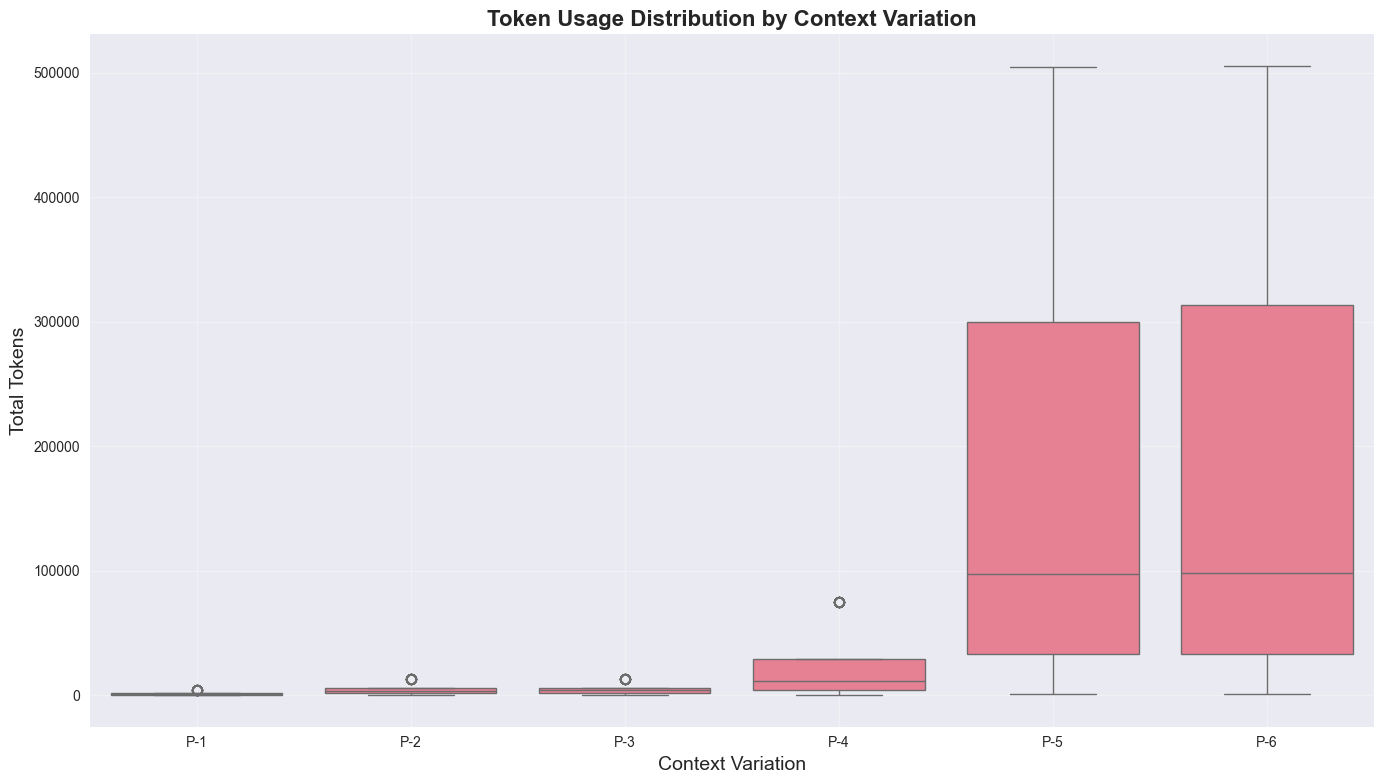

Saved: token_usage_boxplot.png


In [14]:
# 1. Boxplots of token usage distributions
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_data, x='variation', y='total_tokens', order=variations)
plt.title('Token Usage Distribution by Context Variation', fontsize=16, fontweight='bold')
plt.xlabel('Context Variation', fontsize=14)
plt.ylabel('Total Tokens', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('token_usage_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: token_usage_boxplot.png")

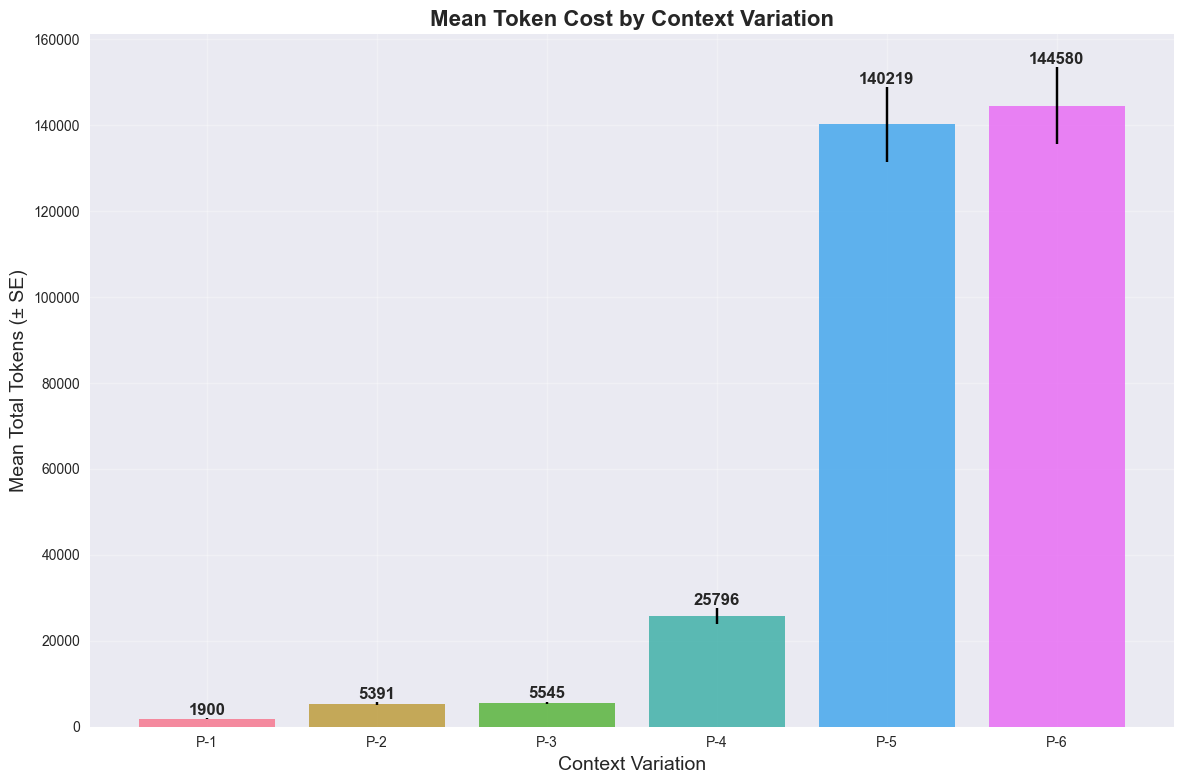

Saved: mean_token_cost_bars.png


In [15]:
# 2. Bar chart with error bars
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate means and standard errors
means = []
sems = []

for variation in variations:
    var_data = combined_data[combined_data['variation'] == variation]['total_tokens']
    means.append(var_data.mean())
    sems.append(var_data.sem())  # Standard error of the mean

bars = ax.bar(variations, means, yerr=sems, capsize=5, alpha=0.8, 
              color=sns.color_palette("husl", len(variations)))

ax.set_title('Mean Token Cost by Context Variation', fontsize=16, fontweight='bold')
ax.set_xlabel('Context Variation', fontsize=14)
ax.set_ylabel('Mean Total Tokens (± SE)', fontsize=14)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, mean, sem) in enumerate(zip(bars, means, sems)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + sem + 50,
            f'{mean:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('mean_token_cost_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: mean_token_cost_bars.png")

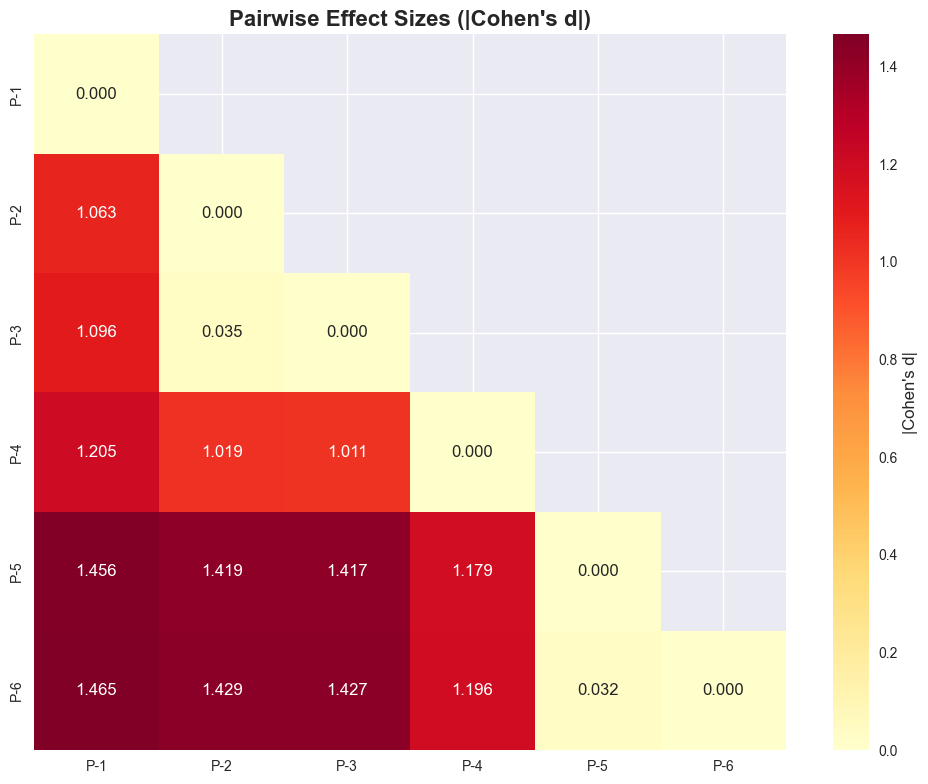

Saved: pairwise_effect_size_heatmap.png


In [16]:
# 3. Heatmap of pairwise effect sizes
# Create effect size matrix
effect_matrix = np.zeros((len(variations), len(variations)))
effect_matrix.fill(np.nan)

# Fill the matrix with Cohen's d values
for _, row in pairwise_df.iterrows():
    comp = row['Comparison']
    var1, var2 = comp.split(' vs ')
    i, j = variations.index(var1), variations.index(var2)
    effect_matrix[i, j] = abs(row['Cohens_D'])  # Use absolute value
    effect_matrix[j, i] = abs(row['Cohens_D'])  # Symmetric

# Set diagonal to 0
np.fill_diagonal(effect_matrix, 0)

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(effect_matrix, dtype=bool), k=1)  # Mask upper triangle
sns.heatmap(effect_matrix, mask=mask, annot=True, fmt='.3f', 
            xticklabels=variations, yticklabels=variations,
            cmap='YlOrRd', cbar_kws={'label': '|Cohen\'s d|'})
plt.title('Pairwise Effect Sizes (|Cohen\'s d|)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('pairwise_effect_size_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: pairwise_effect_size_heatmap.png")

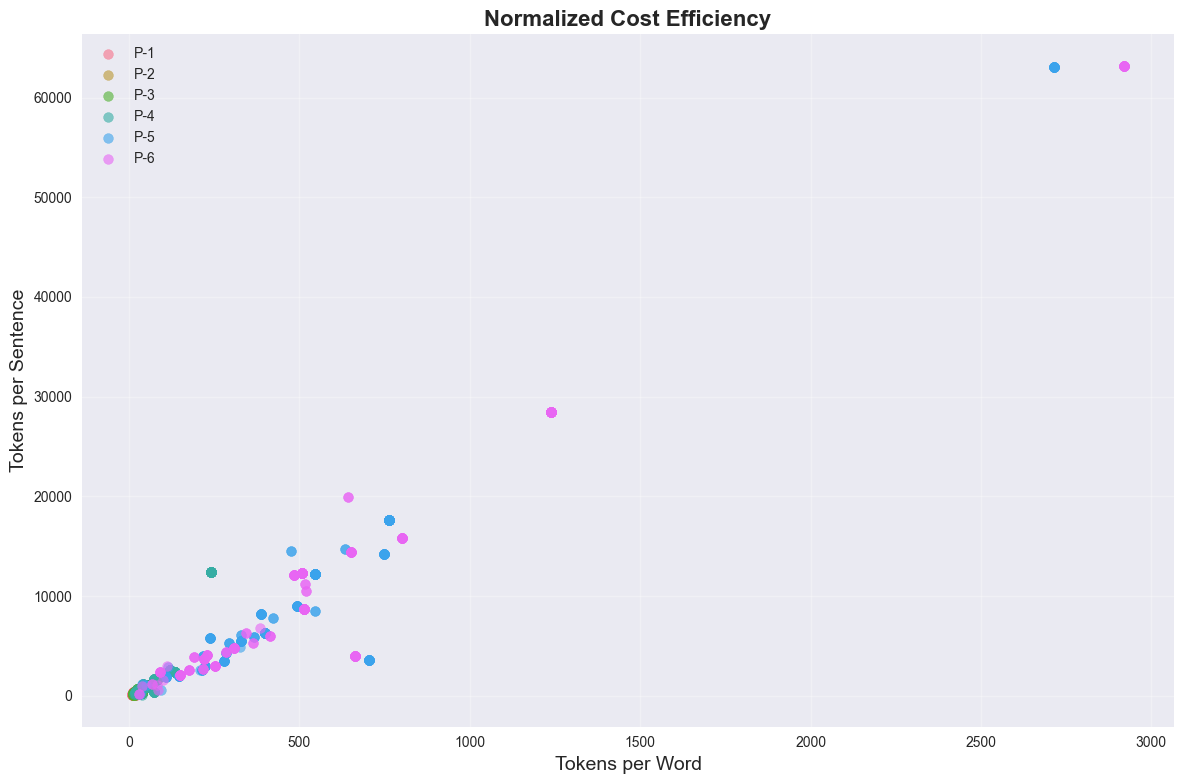

Saved: normalized_cost_efficiency.png


In [17]:
# 4. Optional: Normalized cost efficiency scatterplot
plt.figure(figsize=(12, 8))

# Create scatterplot with different colors for each variation
colors = sns.color_palette("husl", len(variations))
for i, variation in enumerate(variations):
    var_data = combined_data[combined_data['variation'] == variation]
    tokens_per_word = var_data['total_tokens'] / var_data['word_count']
    tokens_per_sentence = var_data['total_tokens'] / var_data['sentence_count']
    
    plt.scatter(tokens_per_word, tokens_per_sentence, 
               c=[colors[i]], label=variation, alpha=0.6, s=50)

plt.xlabel('Tokens per Word', fontsize=14)
plt.ylabel('Tokens per Sentence', fontsize=14)
plt.title('Normalized Cost Efficiency', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('normalized_cost_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: normalized_cost_efficiency.png")

## Publication-Ready Tables

In [13]:
# Table 1: Descriptive Statistics
table1 = descriptive_stats[[
    'Variation', 'Mean_Prompt_Tokens', 'Mean_Completion_Tokens', 
    'Mean_Total_Tokens', 'Prompt_Completion_Ratio', 'Efficiency_Score',
    'Tokens_Per_Word', 'Tokens_Per_Sentence'
]].round(2)

table1_md = table1.to_markdown(index=False)
with open('table1_descriptive_stats.md', 'w') as f:
    f.write("# Table 1: Descriptive Statistics\n\n")
    f.write(table1_md)

table1.to_csv('table1_descriptive_stats.csv', index=False)

print("Table 1: Descriptive Statistics")
display(table1)

Table 1: Descriptive Statistics


,Variation,Mean_Prompt_Tokens,Mean_Completion_Tokens,Mean_Total_Tokens,Prompt_Completion_Ratio,Efficiency_Score,Tokens_Per_Word,Tokens_Per_Sentence
0,P-1,1568.71,331.06,1899.77,4.80,0.18,17.09,244.60
1,P-2,4790.77,599.88,5390.65,8.28,0.11,31.26,489.20
2,P-3,4908.58,636.12,5544.70,7.94,0.12,34.68,621.24
3,P-4,24989.92,806.11,25796.03,24.82,0.05,108.39,3855.95
4,P-5,139352.44,866.39,140218.83,169.82,0.01,610.40,12313.87
5,P-6,143756.08,823.68,144579.75,178.42,0.01,741.38,15434.77


In [14]:
# Table 2: Relative Costs
table2 = ranking_df[['Variation', 'Mean_Total_Tokens', 'Percent_Difference_vs_P1', 'Ranking']].round(2)

table2_md = table2.to_markdown(index=False)
with open('table2_relative_costs.md', 'w') as f:
    f.write("# Table 2: Relative Costs (Baseline = P-1)\n\n")
    f.write(table2_md)

table2.to_csv('table2_relative_costs.csv', index=False)

print("Table 2: Relative Costs (Baseline = P-1)")
display(table2)

Table 2: Relative Costs (Baseline = P-1)


,Variation,Mean_Total_Tokens,Percent_Difference_vs_P1,Ranking
0,P-1,1899.77,0.00,1
1,P-2,5390.65,183.75,2
2,P-3,5544.70,191.86,3
3,P-4,25796.03,1257.85,4
4,P-5,140218.83,7280.83,5
5,P-6,144579.75,7510.38,6


In [15]:
# Table 3: Statistical Results
table3 = pairwise_df[[
    'Comparison', 'Test', 'P_Value', 'Significant', 'Cohens_D', 'Effect_Size_Interpretation'
]].round(4)

table3_md = table3.to_markdown(index=False)
with open('table3_statistical_results.md', 'w') as f:
    f.write("# Table 3: Statistical Significance\n\n")
    f.write(table3_md)
    f.write("\n\n## Overall Test Results\n\n")
    f.write(f"- **Test Used**: {test_used}\n")
    f.write(f"- **Test Statistic**: {test_stat:.4f}\n")
    f.write(f"- **P-value**: {anova_p:.6f}\n")
    f.write(f"- **Significant (p<0.05)**: {anova_p < 0.05}\n")
    f.write(f"- **Effect Size (η²)**: {eta_squared:.4f}\n")
    f.write(f"- **Effect Size Interpretation**: {effect_interpretation}\n")

table3.to_csv('table3_statistical_results.csv', index=False)

print("Table 3: Statistical Significance")
display(table3)

print(f"\nOverall test results:")
print(f"- Test Used: {test_used}")
print(f"- Test Statistic: {test_stat:.4f}")
print(f"- P-value: {anova_p:.6f}")
print(f"- Significant (p<0.05): {anova_p < 0.05}")
print(f"- Effect Size (η²): {eta_squared:.4f}")
print(f"- Effect Size Interpretation: {effect_interpretation}")

Table 3: Statistical Significance


,Comparison,Test,P_Value,Significant,Cohens_D,Effect_Size_Interpretation
0,P-1 vs P-2,Welch t-test,0.0000,True,-1.0632,Large
1,P-1 vs P-3,Welch t-test,0.0000,True,-1.0957,Large
2,P-1 vs P-4,Welch t-test,0.0000,True,-1.2055,Large
3,P-1 vs P-5,Welch t-test,0.0000,True,-1.4561,Large
4,P-1 vs P-6,Welch t-test,0.0000,True,-1.4653,Large
5,P-2 vs P-3,Welch t-test,0.7020,False,-0.0350,Very small
6,P-2 vs P-4,Welch t-test,0.0000,True,-1.0186,Large
7,P-2 vs P-5,Welch t-test,0.0000,True,-1.4187,Large
8,P-2 vs P-6,Welch t-test,0.0000,True,-1.4288,Large
9,P-3 vs P-4,Welch t-test,0.0000,True,-1.0106,Large



Overall test results:
- Test Used: Kruskal-Wallis
- Test Statistic: 956.4520
- P-value: 0.000000
- Significant (p<0.05): True
- Effect Size (η²): 0.6635
- Effect Size Interpretation: Large


## Summary

In [16]:
print("\n" + "="*80)
print("CONTEXT COST ANALYSIS SUMMARY")
print("="*80)

print(f"\nAnalyzed {len(combined_data)} records across {len(variations)} context variations.")
print(f"Variations: {', '.join(variations)}")

print("\nCost Ranking (cheapest to most expensive):")
for _, row in ranking_df.iterrows():
    print(f"{row['Ranking']}. {row['Variation']}: {row['Mean_Total_Tokens']:.0f} tokens "
          f"({row['Percent_Difference_vs_P1']:+.1f}% vs P-1)")

print(f"\nStatistical Test Results:")
print(f"- Overall difference significant: {anova_p < 0.05} (p={anova_p:.6f})")
print(f"- Effect size: {effect_interpretation} (η²={eta_squared:.4f})")

significant_pairs = pairwise_df[pairwise_df['Significant'] == True]
print(f"\nSignificant pairwise differences: {len(significant_pairs)} out of {len(pairwise_df)}")

if len(significant_pairs) > 0:
    print("Significant comparisons:")
    for _, row in significant_pairs.iterrows():
        print(f"  - {row['Comparison']}: p={row['P_Value']:.4f}, d={row['Cohens_D']:.3f} ({row['Effect_Size_Interpretation']})")

print("\nGenerated Files:")
files = [
    'context_cost_analysis_results.csv',
    'context_cost_ranking.csv', 
    'context_cost_significance.csv',
    'context_cost_effect_sizes.csv',
    'token_usage_boxplot.png',
    'mean_token_cost_bars.png',
    'pairwise_effect_size_heatmap.png',
    'normalized_cost_efficiency.png',
    'table1_descriptive_stats.md',
    'table2_relative_costs.md',
    'table3_statistical_results.md',
    'table1_descriptive_stats.csv',
    'table2_relative_costs.csv',
    'table3_statistical_results.csv'
]

for file in files:
    print(f"  ✓ {file}")

print("\n" + "="*80)


CONTEXT COST ANALYSIS SUMMARY

Analyzed 1440 records across 6 context variations.
Variations: P-1, P-2, P-3, P-4, P-5, P-6

Cost Ranking (cheapest to most expensive):
1. P-1: 1900 tokens (+0.0% vs P-1)
2. P-2: 5391 tokens (+183.8% vs P-1)
3. P-3: 5545 tokens (+191.9% vs P-1)
4. P-4: 25796 tokens (+1257.8% vs P-1)
5. P-5: 140219 tokens (+7280.8% vs P-1)
6. P-6: 144580 tokens (+7510.4% vs P-1)

Statistical Test Results:
- Overall difference significant: True (p=0.000000)
- Effect size: Large (η²=0.6635)

Significant pairwise differences: 13 out of 15
Significant comparisons:
  - P-1 vs P-2: p=0.0000, d=-1.063 (Large)
  - P-1 vs P-3: p=0.0000, d=-1.096 (Large)
  - P-1 vs P-4: p=0.0000, d=-1.205 (Large)
  - P-1 vs P-5: p=0.0000, d=-1.456 (Large)
  - P-1 vs P-6: p=0.0000, d=-1.465 (Large)
  - P-2 vs P-4: p=0.0000, d=-1.019 (Large)
  - P-2 vs P-5: p=0.0000, d=-1.419 (Large)
  - P-2 vs P-6: p=0.0000, d=-1.429 (Large)
  - P-3 vs P-4: p=0.0000, d=-1.011 (Large)
  - P-3 vs P-5: p=0.0000, d=-1.4

## Input vs Output Token Analysis

This section provides a detailed breakdown of costs separated into input (prompt) tokens and output (completion) tokens, with the same statistical rigor applied to each component.

### Input Token (Prompt) Analysis

In [17]:
# Input Token Descriptive Statistics
print("=== INPUT TOKEN (PROMPT) ANALYSIS ===\n")

# Calculate descriptive statistics for input tokens
input_stats_list = []
for variation in sorted(combined_data['variation'].unique()):
    var_data = combined_data[combined_data['variation'] == variation]
    prompt_stats = var_data['prompt_tokens'].describe()
    
    input_stats_list.append({
        'Variation': variation,
        'Count': len(var_data),
        'Mean_Prompt_Tokens': prompt_stats['mean'],
        'Median_Prompt_Tokens': prompt_stats['50%'],
        'Min_Prompt_Tokens': prompt_stats['min'],
        'Max_Prompt_Tokens': prompt_stats['max'],
        'Std_Prompt_Tokens': prompt_stats['std'],
        'Q1_Prompt_Tokens': prompt_stats['25%'],
        'Q3_Prompt_Tokens': prompt_stats['75%']
    })

input_descriptive_stats = pd.DataFrame(input_stats_list)
print("Input Token Descriptive Statistics:")
display(input_descriptive_stats.round(2))

# Input Token Rankings
baseline_input_cost = input_descriptive_stats[input_descriptive_stats['Variation'] == 'P-1']['Mean_Prompt_Tokens'].iloc[0]

input_ranking_data = []
for _, row in input_descriptive_stats.iterrows():
    variation = row['Variation']
    mean_tokens = row['Mean_Prompt_Tokens']
    
    if variation == 'P-1':
        pct_diff = 0.0
    else:
        pct_diff = ((mean_tokens - baseline_input_cost) / baseline_input_cost) * 100
    
    input_ranking_data.append({
        'Variation': variation,
        'Mean_Prompt_Tokens': mean_tokens,
        'Percent_Difference_vs_P1': pct_diff
    })

input_ranking_df = pd.DataFrame(input_ranking_data)
input_ranking_df = input_ranking_df.sort_values('Mean_Prompt_Tokens')
input_ranking_df['Ranking'] = range(1, len(input_ranking_df) + 1)

print(f"\nInput Token Cost Ranking (baseline = P-1):")
display(input_ranking_df.round(2))

# Save input token results
input_descriptive_stats.to_csv('input_token_analysis_results.csv', index=False)
input_ranking_df.to_csv('input_token_ranking.csv', index=False)
print("\nSaved input token analysis to:")
print("- 'input_token_analysis_results.csv'")
print("- 'input_token_ranking.csv'")

=== INPUT TOKEN (PROMPT) ANALYSIS ===

Input Token Descriptive Statistics:


,Variation,Count,Mean_Prompt_Tokens,Median_Prompt_Tokens,Min_Prompt_Tokens,Max_Prompt_Tokens,Std_Prompt_Tokens,Q1_Prompt_Tokens,Q3_Prompt_Tokens
0,P-1,240,1568.71,1035.0,99.0,3778.0,1305.75,526.0,1811.0
1,P-2,240,4790.77,3461.0,495.0,11477.0,3930.32,1577.0,5194.0
2,P-3,240,4908.58,3646.0,508.0,11648.0,3981.80,1664.0,5399.0
3,P-4,240,24989.92,11091.0,628.0,72745.0,27368.88,4333.0,28011.0
4,P-5,240,139352.44,96492.0,1116.0,504021.0,133835.66,32500.0,297730.0
5,P-6,240,143756.08,97368.0,1252.0,504743.0,137253.74,33230.0,311402.0



Input Token Cost Ranking (baseline = P-1):


,Variation,Mean_Prompt_Tokens,Percent_Difference_vs_P1,Ranking
0,P-1,1568.71,0.00,1
1,P-2,4790.77,205.40,2
2,P-3,4908.58,212.91,3
3,P-4,24989.92,1493.03,4
4,P-5,139352.44,8783.26,5
5,P-6,143756.08,9063.98,6



Saved input token analysis to:
- 'input_token_analysis_results.csv'
- 'input_token_ranking.csv'


In [18]:
# Input Token Statistical Testing
print("\n=== INPUT TOKEN STATISTICAL ANALYSIS ===\n")

# Prepare input token data for statistical testing
input_token_data_by_variation = []
for variation in variations:
    var_tokens = combined_data[combined_data['variation'] == variation]['prompt_tokens'].values
    input_token_data_by_variation.append(var_tokens)

# Test for normality on input tokens
print("Testing input tokens for normality:")
input_all_normal = True
for i, (variation, data) in enumerate(zip(variations, input_token_data_by_variation)):
    if len(data) > 5000:
        sample_data = np.random.choice(data, 5000, replace=False)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    is_normal = p_value > 0.05
    
    if not is_normal:
        input_all_normal = False
    
    print(f"{variation}: W={stat:.4f}, p={p_value:.6f}, Normal: {is_normal}")

print(f"\nAll input token distributions normal: {input_all_normal}")

# Perform statistical test on input tokens
if input_all_normal:
    print("\nPerforming one-way ANOVA on input tokens...")
    input_f_stat, input_anova_p = f_oneway(*input_token_data_by_variation)
    input_test_used = "One-way ANOVA"
    input_test_stat = input_f_stat
    
    # Calculate eta-squared
    ss_between = sum([len(data) * (np.mean(data) - np.mean(np.concatenate(input_token_data_by_variation)))**2 
                     for data in input_token_data_by_variation])
    ss_total = sum([(x - np.mean(np.concatenate(input_token_data_by_variation)))**2 
                   for data in input_token_data_by_variation for x in data])
    input_eta_squared = ss_between / ss_total
else:
    print("\nPerforming Kruskal-Wallis test on input tokens...")
    input_h_stat, input_anova_p = kruskal(*input_token_data_by_variation)
    input_test_used = "Kruskal-Wallis"
    input_test_stat = input_h_stat
    
    total_n = sum([len(data) for data in input_token_data_by_variation])
    input_eta_squared = (input_h_stat - len(variations) + 1) / (total_n - len(variations))

print(f"Test: {input_test_used}")
print(f"Test statistic: {input_test_stat:.4f}")
print(f"P-value: {input_anova_p:.6f}")
print(f"Significant (p<0.05): {input_anova_p < 0.05}")
print(f"Effect size (η²): {input_eta_squared:.4f}")

# Interpret effect size
if input_eta_squared < 0.01:
    input_effect_interpretation = "Very small"
elif input_eta_squared < 0.06:
    input_effect_interpretation = "Small"
elif input_eta_squared < 0.14:
    input_effect_interpretation = "Medium"
else:
    input_effect_interpretation = "Large"

print(f"Effect size interpretation: {input_effect_interpretation}")

# Pairwise comparisons for input tokens
print("\nPairwise t-tests for input tokens (Welch's correction):")
input_pairwise_results = []

for i in range(len(variations)):
    for j in range(i+1, len(variations)):
        var1, var2 = variations[i], variations[j]
        data1, data2 = input_token_data_by_variation[i], input_token_data_by_variation[j]
        
        # Perform Welch's t-test
        t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
        
        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                             (len(data2) - 1) * np.var(data2, ddof=1)) / 
                            (len(data1) + len(data2) - 2))
        cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
        
        # Interpret Cohen's d
        abs_d = abs(cohens_d)
        if abs_d < 0.2:
            d_interpretation = "Very small"
        elif abs_d < 0.5:
            d_interpretation = "Small"
        elif abs_d < 0.8:
            d_interpretation = "Medium"
        else:
            d_interpretation = "Large"
        
        input_pairwise_results.append({
            'Comparison': f"{var1} vs {var2}",
            'Test': "Welch t-test",
            'T_Statistic': t_stat,
            'P_Value': p_val,
            'Significant': p_val < 0.05,
            'Cohens_D': cohens_d,
            'Effect_Size_Interpretation': d_interpretation
        })
        
        print(f"{var1} vs {var2}: t={t_stat:.3f}, p={p_val:.6f}, d={cohens_d:.3f} ({d_interpretation})")

input_pairwise_df = pd.DataFrame(input_pairwise_results)

# Save input token statistical results
input_significance_results = {
    'Overall_Test': input_test_used,
    'Overall_Statistic': input_test_stat,
    'Overall_P_Value': input_anova_p,
    'Overall_Significant': input_anova_p < 0.05,
    'Effect_Size_Eta_Squared': input_eta_squared,
    'Effect_Size_Interpretation': input_effect_interpretation
}

input_significance_df = pd.DataFrame([input_significance_results])
input_significance_df.to_csv('input_token_significance.csv', index=False)
input_pairwise_df.to_csv('input_token_effect_sizes.csv', index=False)

print("\nSaved input token statistical results to:")
print("- 'input_token_significance.csv'")
print("- 'input_token_effect_sizes.csv'")


=== INPUT TOKEN STATISTICAL ANALYSIS ===

Testing input tokens for normality:
P-1: W=0.8095, p=0.000000, Normal: False
P-2: W=0.8029, p=0.000000, Normal: False
P-3: W=0.8092, p=0.000000, Normal: False
P-4: W=0.7322, p=0.000000, Normal: False
P-5: W=0.8083, p=0.000000, Normal: False
P-6: W=0.8109, p=0.000000, Normal: False

All input token distributions normal: False

Performing Kruskal-Wallis test on input tokens...
Test: Kruskal-Wallis
Test statistic: 981.3173
P-value: 0.000000
Significant (p<0.05): True
Effect size (η²): 0.6808
Effect size interpretation: Large

Pairwise t-tests for input tokens (Welch's correction):
P-1 vs P-2: t=-12.052, p=0.000000, d=-1.100 (Large)
P-1 vs P-3: t=-12.347, p=0.000000, d=-1.127 (Large)
P-1 vs P-4: t=-13.242, p=0.000000, d=-1.209 (Large)
P-1 vs P-5: t=-15.948, p=0.000000, d=-1.456 (Large)
P-1 vs P-6: t=-16.048, p=0.000000, d=-1.465 (Large)
P-2 vs P-3: t=-0.326, p=0.744401, d=-0.030 (Very small)
P-2 vs P-4: t=-11.317, p=0.000000, d=-1.033 (Large)
P-2 

### Output Token (Completion) Analysis

In [19]:
# Output Token Descriptive Statistics
print("=== OUTPUT TOKEN (COMPLETION) ANALYSIS ===\n")

# Calculate descriptive statistics for output tokens
output_stats_list = []
for variation in sorted(combined_data['variation'].unique()):
    var_data = combined_data[combined_data['variation'] == variation]
    completion_stats = var_data['completion_tokens'].describe()
    
    output_stats_list.append({
        'Variation': variation,
        'Count': len(var_data),
        'Mean_Completion_Tokens': completion_stats['mean'],
        'Median_Completion_Tokens': completion_stats['50%'],
        'Min_Completion_Tokens': completion_stats['min'],
        'Max_Completion_Tokens': completion_stats['max'],
        'Std_Completion_Tokens': completion_stats['std'],
        'Q1_Completion_Tokens': completion_stats['25%'],
        'Q3_Completion_Tokens': completion_stats['75%']
    })

output_descriptive_stats = pd.DataFrame(output_stats_list)
print("Output Token Descriptive Statistics:")
display(output_descriptive_stats.round(2))

# Output Token Rankings
baseline_output_cost = output_descriptive_stats[output_descriptive_stats['Variation'] == 'P-1']['Mean_Completion_Tokens'].iloc[0]

output_ranking_data = []
for _, row in output_descriptive_stats.iterrows():
    variation = row['Variation']
    mean_tokens = row['Mean_Completion_Tokens']
    
    if variation == 'P-1':
        pct_diff = 0.0
    else:
        pct_diff = ((mean_tokens - baseline_output_cost) / baseline_output_cost) * 100
    
    output_ranking_data.append({
        'Variation': variation,
        'Mean_Completion_Tokens': mean_tokens,
        'Percent_Difference_vs_P1': pct_diff
    })

output_ranking_df = pd.DataFrame(output_ranking_data)
output_ranking_df = output_ranking_df.sort_values('Mean_Completion_Tokens')
output_ranking_df['Ranking'] = range(1, len(output_ranking_df) + 1)

print(f"\nOutput Token Cost Ranking (baseline = P-1):")
display(output_ranking_df.round(2))

# Save output token results
output_descriptive_stats.to_csv('output_token_analysis_results.csv', index=False)
output_ranking_df.to_csv('output_token_ranking.csv', index=False)
print("\nSaved output token analysis to:")
print("- 'output_token_analysis_results.csv'")
print("- 'output_token_ranking.csv'")

=== OUTPUT TOKEN (COMPLETION) ANALYSIS ===

Output Token Descriptive Statistics:


,Variation,Count,Mean_Completion_Tokens,Median_Completion_Tokens,Min_Completion_Tokens,Max_Completion_Tokens,Std_Completion_Tokens,Q1_Completion_Tokens,Q3_Completion_Tokens
0,P-1,240,331.06,261.0,15.0,751.0,252.82,152.0,361.0
1,P-2,240,599.88,508.0,28.0,1325.0,448.42,244.0,749.0
2,P-3,240,636.12,539.0,23.0,1370.0,462.43,250.0,766.0
3,P-4,240,806.11,616.0,40.0,1843.0,635.29,277.0,947.0
4,P-5,240,866.39,630.0,51.0,2036.0,699.96,341.0,994.0
5,P-6,240,823.68,644.0,60.0,1834.0,620.98,346.0,990.0



Output Token Cost Ranking (baseline = P-1):


,Variation,Mean_Completion_Tokens,Percent_Difference_vs_P1,Ranking
0,P-1,331.06,0.00,1
1,P-2,599.88,81.20,2
2,P-3,636.12,92.15,3
3,P-4,806.11,143.49,4
5,P-6,823.68,148.80,5
4,P-5,866.39,161.70,6



Saved output token analysis to:
- 'output_token_analysis_results.csv'
- 'output_token_ranking.csv'


In [20]:
# Output Token Statistical Testing
print("\n=== OUTPUT TOKEN STATISTICAL ANALYSIS ===\n")

# Prepare output token data for statistical testing
output_token_data_by_variation = []
for variation in variations:
    var_tokens = combined_data[combined_data['variation'] == variation]['completion_tokens'].values
    output_token_data_by_variation.append(var_tokens)

# Test for normality on output tokens
print("Testing output tokens for normality:")
output_all_normal = True
for i, (variation, data) in enumerate(zip(variations, output_token_data_by_variation)):
    if len(data) > 5000:
        sample_data = np.random.choice(data, 5000, replace=False)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    is_normal = p_value > 0.05
    
    if not is_normal:
        output_all_normal = False
    
    print(f"{variation}: W={stat:.4f}, p={p_value:.6f}, Normal: {is_normal}")

print(f"\nAll output token distributions normal: {output_all_normal}")

# Perform statistical test on output tokens
if output_all_normal:
    print("\nPerforming one-way ANOVA on output tokens...")
    output_f_stat, output_anova_p = f_oneway(*output_token_data_by_variation)
    output_test_used = "One-way ANOVA"
    output_test_stat = output_f_stat
    
    # Calculate eta-squared
    ss_between = sum([len(data) * (np.mean(data) - np.mean(np.concatenate(output_token_data_by_variation)))**2 
                     for data in output_token_data_by_variation])
    ss_total = sum([(x - np.mean(np.concatenate(output_token_data_by_variation)))**2 
                   for data in output_token_data_by_variation for x in data])
    output_eta_squared = ss_between / ss_total
else:
    print("\nPerforming Kruskal-Wallis test on output tokens...")
    output_h_stat, output_anova_p = kruskal(*output_token_data_by_variation)
    output_test_used = "Kruskal-Wallis"
    output_test_stat = output_h_stat
    
    total_n = sum([len(data) for data in output_token_data_by_variation])
    output_eta_squared = (output_h_stat - len(variations) + 1) / (total_n - len(variations))

print(f"Test: {output_test_used}")
print(f"Test statistic: {output_test_stat:.4f}")
print(f"P-value: {output_anova_p:.6f}")
print(f"Significant (p<0.05): {output_anova_p < 0.05}")
print(f"Effect size (η²): {output_eta_squared:.4f}")

# Interpret effect size
if output_eta_squared < 0.01:
    output_effect_interpretation = "Very small"
elif output_eta_squared < 0.06:
    output_effect_interpretation = "Small"
elif output_eta_squared < 0.14:
    output_effect_interpretation = "Medium"
else:
    output_effect_interpretation = "Large"

print(f"Effect size interpretation: {output_effect_interpretation}")

# Pairwise comparisons for output tokens
print("\nPairwise t-tests for output tokens (Welch's correction):")
output_pairwise_results = []

for i in range(len(variations)):
    for j in range(i+1, len(variations)):
        var1, var2 = variations[i], variations[j]
        data1, data2 = output_token_data_by_variation[i], output_token_data_by_variation[j]
        
        # Perform Welch's t-test
        t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
        
        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                             (len(data2) - 1) * np.var(data2, ddof=1)) / 
                            (len(data1) + len(data2) - 2))
        cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std
        
        # Interpret Cohen's d
        abs_d = abs(cohens_d)
        if abs_d < 0.2:
            d_interpretation = "Very small"
        elif abs_d < 0.5:
            d_interpretation = "Small"
        elif abs_d < 0.8:
            d_interpretation = "Medium"
        else:
            d_interpretation = "Large"
        
        output_pairwise_results.append({
            'Comparison': f"{var1} vs {var2}",
            'Test': "Welch t-test",
            'T_Statistic': t_stat,
            'P_Value': p_val,
            'Significant': p_val < 0.05,
            'Cohens_D': cohens_d,
            'Effect_Size_Interpretation': d_interpretation
        })
        
        print(f"{var1} vs {var2}: t={t_stat:.3f}, p={p_val:.6f}, d={cohens_d:.3f} ({d_interpretation})")

output_pairwise_df = pd.DataFrame(output_pairwise_results)

# Save output token statistical results
output_significance_results = {
    'Overall_Test': output_test_used,
    'Overall_Statistic': output_test_stat,
    'Overall_P_Value': output_anova_p,
    'Overall_Significant': output_anova_p < 0.05,
    'Effect_Size_Eta_Squared': output_eta_squared,
    'Effect_Size_Interpretation': output_effect_interpretation
}

output_significance_df = pd.DataFrame([output_significance_results])
output_significance_df.to_csv('output_token_significance.csv', index=False)
output_pairwise_df.to_csv('output_token_effect_sizes.csv', index=False)

print("\nSaved output token statistical results to:")
print("- 'output_token_significance.csv'")
print("- 'output_token_effect_sizes.csv'")


=== OUTPUT TOKEN STATISTICAL ANALYSIS ===

Testing output tokens for normality:
P-1: W=0.8395, p=0.000000, Normal: False
P-2: W=0.8595, p=0.000000, Normal: False
P-3: W=0.8661, p=0.000000, Normal: False
P-4: W=0.8421, p=0.000000, Normal: False
P-5: W=0.8259, p=0.000000, Normal: False
P-6: W=0.8495, p=0.000000, Normal: False

All output token distributions normal: False

Performing Kruskal-Wallis test on output tokens...
Test: Kruskal-Wallis
Test statistic: 135.1747
P-value: 0.000000
Significant (p<0.05): True
Effect size (η²): 0.0908
Effect size interpretation: Medium

Pairwise t-tests for output tokens (Welch's correction):
P-1 vs P-2: t=-8.090, p=0.000000, d=-0.739 (Medium)
P-1 vs P-3: t=-8.967, p=0.000000, d=-0.819 (Large)
P-1 vs P-4: t=-10.763, p=0.000000, d=-0.983 (Large)
P-1 vs P-5: t=-11.144, p=0.000000, d=-1.017 (Large)
P-1 vs P-6: t=-11.382, p=0.000000, d=-1.039 (Large)
P-2 vs P-3: t=-0.872, p=0.383901, d=-0.080 (Very small)
P-2 vs P-4: t=-4.109, p=0.000048, d=-0.375 (Small)


### Input vs Output Token Visualizations

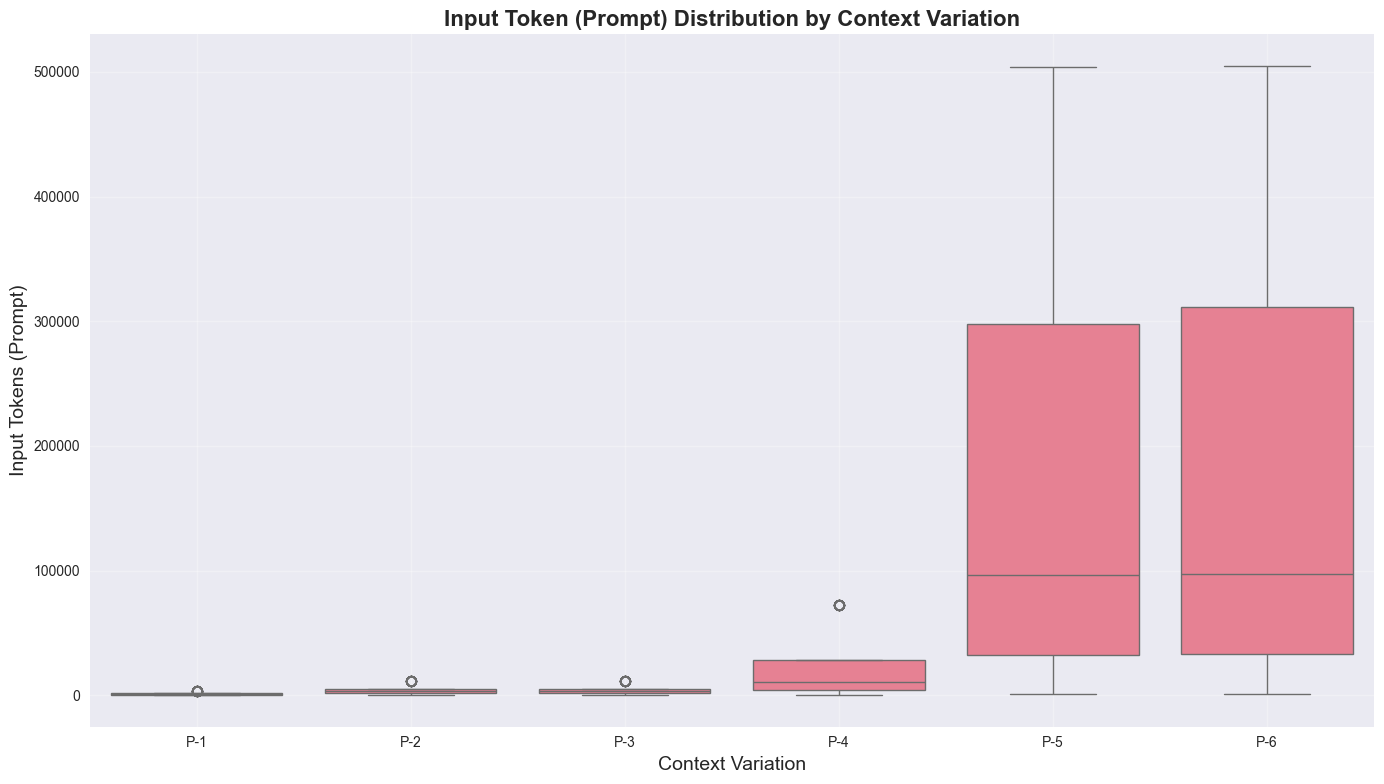

Saved: input_token_boxplot.png


In [21]:
# Input Token Boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_data, x='variation', y='prompt_tokens', order=variations)
plt.title('Input Token (Prompt) Distribution by Context Variation', fontsize=16, fontweight='bold')
plt.xlabel('Context Variation', fontsize=14)
plt.ylabel('Input Tokens (Prompt)', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('input_token_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: input_token_boxplot.png")

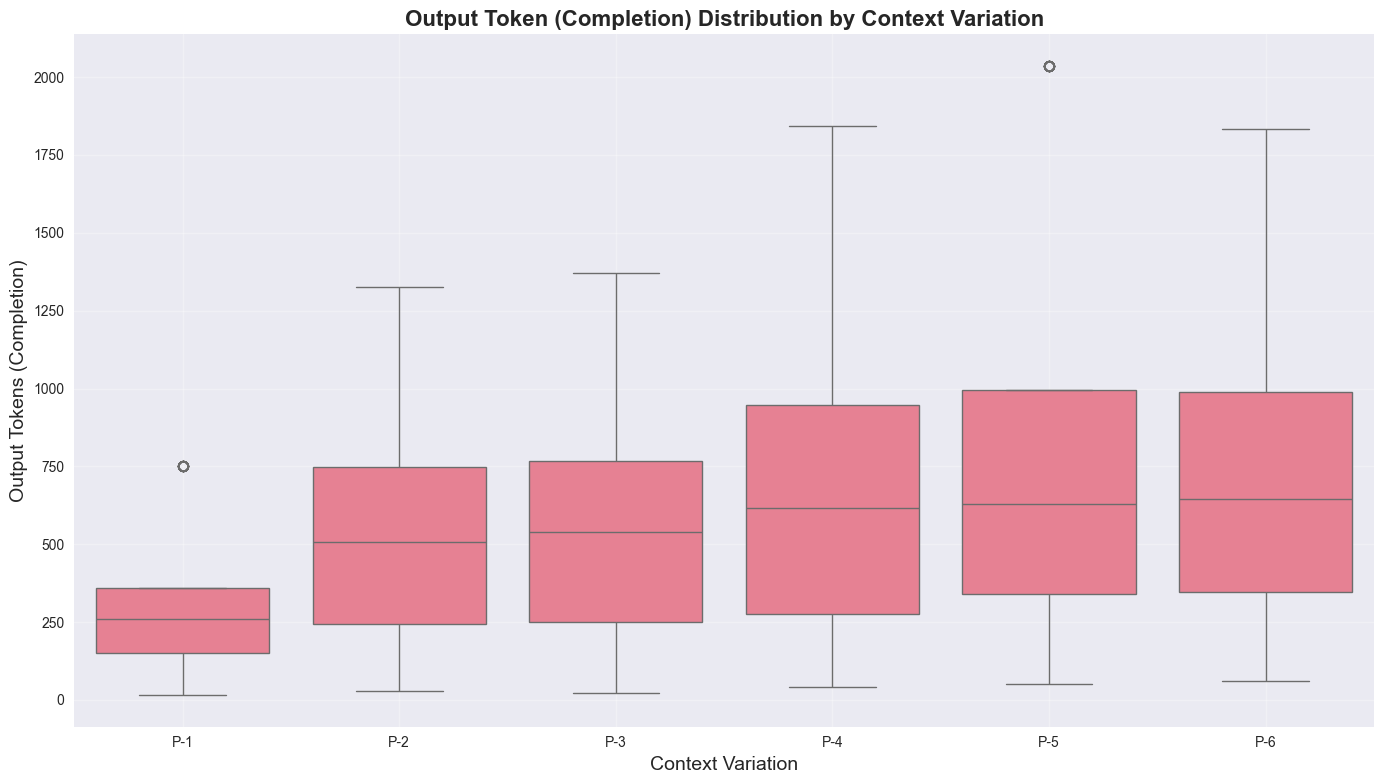

Saved: output_token_boxplot.png


In [22]:
# Output Token Boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_data, x='variation', y='completion_tokens', order=variations)
plt.title('Output Token (Completion) Distribution by Context Variation', fontsize=16, fontweight='bold')
plt.xlabel('Context Variation', fontsize=14)
plt.ylabel('Output Tokens (Completion)', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output_token_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: output_token_boxplot.png")

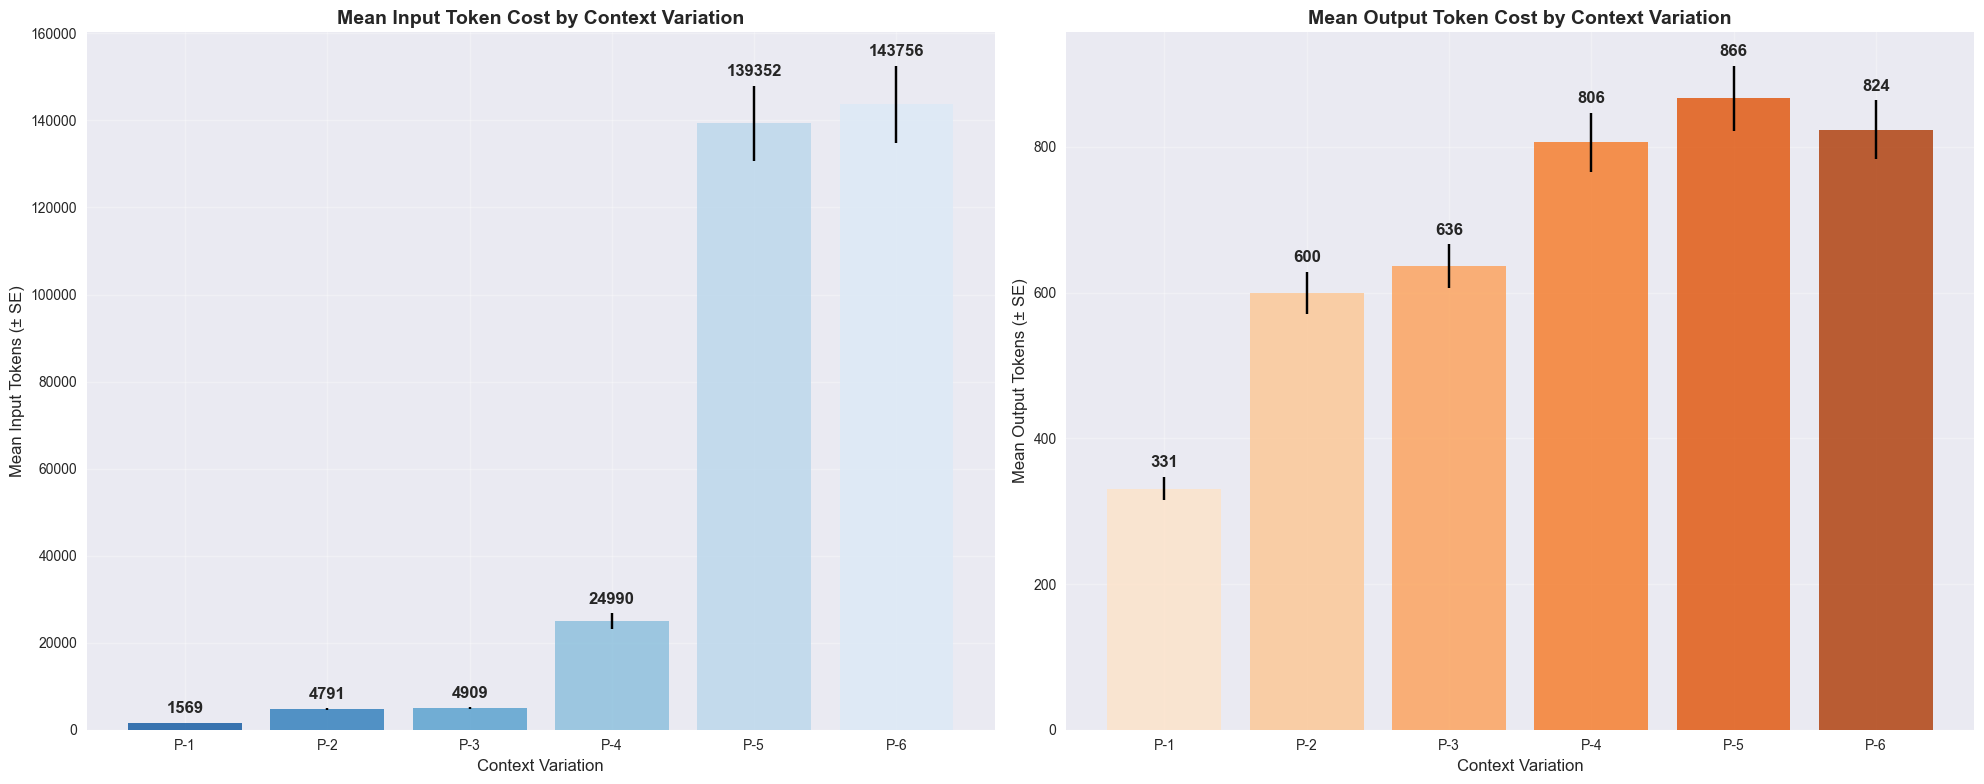

Saved: input_vs_output_token_comparison.png


In [23]:
# Side-by-side Input vs Output Token Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Input tokens bar chart
input_means = []
input_sems = []
for variation in variations:
    var_data = combined_data[combined_data['variation'] == variation]['prompt_tokens']
    input_means.append(var_data.mean())
    input_sems.append(var_data.sem())

bars1 = ax1.bar(variations, input_means, yerr=input_sems, capsize=5, alpha=0.8, 
                color=sns.color_palette("Blues_r", len(variations)))
ax1.set_title('Mean Input Token Cost by Context Variation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Context Variation', fontsize=12)
ax1.set_ylabel('Mean Input Tokens (± SE)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, mean, sem) in enumerate(zip(bars1, input_means, input_sems)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + sem + max(input_means)*0.01,
             f'{mean:.0f}', ha='center', va='bottom', fontweight='bold')

# Output tokens bar chart
output_means = []
output_sems = []
for variation in variations:
    var_data = combined_data[combined_data['variation'] == variation]['completion_tokens']
    output_means.append(var_data.mean())
    output_sems.append(var_data.sem())

bars2 = ax2.bar(variations, output_means, yerr=output_sems, capsize=5, alpha=0.8, 
                color=sns.color_palette("Oranges", len(variations)))
ax2.set_title('Mean Output Token Cost by Context Variation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Context Variation', fontsize=12)
ax2.set_ylabel('Mean Output Tokens (± SE)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, mean, sem) in enumerate(zip(bars2, output_means, output_sems)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + sem + max(output_means)*0.01,
             f'{mean:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('input_vs_output_token_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: input_vs_output_token_comparison.png")

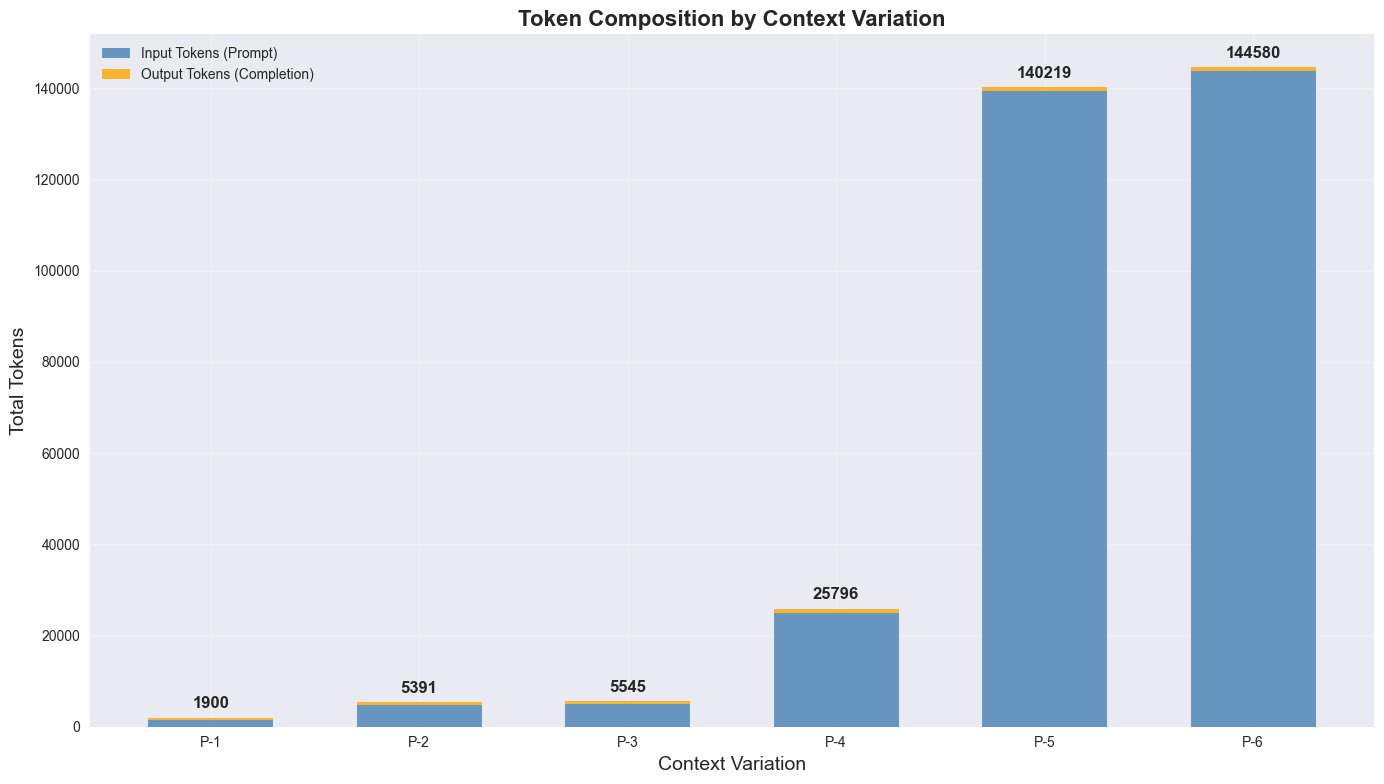

Saved: token_composition_stacked.png


In [24]:
# Stacked Bar Chart showing Token Composition
plt.figure(figsize=(14, 8))

# Calculate means for stacked chart
input_means_stack = [combined_data[combined_data['variation'] == var]['prompt_tokens'].mean() 
                     for var in variations]
output_means_stack = [combined_data[combined_data['variation'] == var]['completion_tokens'].mean() 
                      for var in variations]

# Create stacked bar chart
width = 0.6
p1 = plt.bar(variations, input_means_stack, width, label='Input Tokens (Prompt)', 
             color='steelblue', alpha=0.8)
p2 = plt.bar(variations, output_means_stack, width, bottom=input_means_stack, 
             label='Output Tokens (Completion)', color='orange', alpha=0.8)

plt.title('Token Composition by Context Variation', fontsize=16, fontweight='bold')
plt.xlabel('Context Variation', fontsize=14)
plt.ylabel('Total Tokens', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add total value labels on top of bars
total_means = [i + o for i, o in zip(input_means_stack, output_means_stack)]
for i, (var, total) in enumerate(zip(variations, total_means)):
    plt.text(i, total + max(total_means)*0.01, f'{total:.0f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('token_composition_stacked.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: token_composition_stacked.png")

### Publication-Ready Tables for Input/Output Analysis

In [25]:
# Table 4: Input Token Analysis
input_table = input_descriptive_stats[['Variation', 'Mean_Prompt_Tokens', 'Median_Prompt_Tokens', 
                                       'Min_Prompt_Tokens', 'Max_Prompt_Tokens', 'Std_Prompt_Tokens']].round(2)

input_table_md = input_table.to_markdown(index=False)
with open('table4_input_token_stats.md', 'w') as f:
    f.write("# Table 4: Input Token (Prompt) Statistics\n\n")
    f.write(input_table_md)

input_table.to_csv('table4_input_token_stats.csv', index=False)

print("Table 4: Input Token Statistics")
display(input_table)

# Table 5: Input Token Rankings
input_ranking_table = input_ranking_df.round(2)
input_ranking_table_md = input_ranking_table.to_markdown(index=False)
with open('table5_input_token_ranking.md', 'w') as f:
    f.write("# Table 5: Input Token Cost Ranking (Baseline = P-1)\n\n")
    f.write(input_ranking_table_md)

input_ranking_table.to_csv('table5_input_token_ranking.csv', index=False)

print("\nTable 5: Input Token Rankings")
display(input_ranking_table)

Table 4: Input Token Statistics


,Variation,Mean_Prompt_Tokens,Median_Prompt_Tokens,Min_Prompt_Tokens,Max_Prompt_Tokens,Std_Prompt_Tokens
0,P-1,1568.71,1035.0,99.0,3778.0,1305.75
1,P-2,4790.77,3461.0,495.0,11477.0,3930.32
2,P-3,4908.58,3646.0,508.0,11648.0,3981.80
3,P-4,24989.92,11091.0,628.0,72745.0,27368.88
4,P-5,139352.44,96492.0,1116.0,504021.0,133835.66
5,P-6,143756.08,97368.0,1252.0,504743.0,137253.74



Table 5: Input Token Rankings


,Variation,Mean_Prompt_Tokens,Percent_Difference_vs_P1,Ranking
0,P-1,1568.71,0.00,1
1,P-2,4790.77,205.40,2
2,P-3,4908.58,212.91,3
3,P-4,24989.92,1493.03,4
4,P-5,139352.44,8783.26,5
5,P-6,143756.08,9063.98,6


In [26]:
# Table 6: Output Token Analysis
output_table = output_descriptive_stats[['Variation', 'Mean_Completion_Tokens', 'Median_Completion_Tokens', 
                                         'Min_Completion_Tokens', 'Max_Completion_Tokens', 'Std_Completion_Tokens']].round(2)

output_table_md = output_table.to_markdown(index=False)
with open('table6_output_token_stats.md', 'w') as f:
    f.write("# Table 6: Output Token (Completion) Statistics\n\n")
    f.write(output_table_md)

output_table.to_csv('table6_output_token_stats.csv', index=False)

print("Table 6: Output Token Statistics")
display(output_table)

# Table 7: Output Token Rankings
output_ranking_table = output_ranking_df.round(2)
output_ranking_table_md = output_ranking_table.to_markdown(index=False)
with open('table7_output_token_ranking.md', 'w') as f:
    f.write("# Table 7: Output Token Cost Ranking (Baseline = P-1)\n\n")
    f.write(output_ranking_table_md)

output_ranking_table.to_csv('table7_output_token_ranking.csv', index=False)

print("\nTable 7: Output Token Rankings")
display(output_ranking_table)

Table 6: Output Token Statistics


,Variation,Mean_Completion_Tokens,Median_Completion_Tokens,Min_Completion_Tokens,Max_Completion_Tokens,Std_Completion_Tokens
0,P-1,331.06,261.0,15.0,751.0,252.82
1,P-2,599.88,508.0,28.0,1325.0,448.42
2,P-3,636.12,539.0,23.0,1370.0,462.43
3,P-4,806.11,616.0,40.0,1843.0,635.29
4,P-5,866.39,630.0,51.0,2036.0,699.96
5,P-6,823.68,644.0,60.0,1834.0,620.98



Table 7: Output Token Rankings


,Variation,Mean_Completion_Tokens,Percent_Difference_vs_P1,Ranking
0,P-1,331.06,0.00,1
1,P-2,599.88,81.20,2
2,P-3,636.12,92.15,3
3,P-4,806.11,143.49,4
5,P-6,823.68,148.80,5
4,P-5,866.39,161.70,6


In [27]:
# Table 8: Input Token Statistical Results
input_stats_table = input_pairwise_df[['Comparison', 'Test', 'P_Value', 'Significant', 
                                       'Cohens_D', 'Effect_Size_Interpretation']].round(4)

input_stats_table_md = input_stats_table.to_markdown(index=False)
with open('table8_input_token_statistical_results.md', 'w') as f:
    f.write("# Table 8: Input Token Statistical Results\n\n")
    f.write(input_stats_table_md)
    f.write("\n\n## Overall Test Results\n\n")
    f.write(f"- **Test Used**: {input_test_used}\n")
    f.write(f"- **Test Statistic**: {input_test_stat:.4f}\n")
    f.write(f"- **P-value**: {input_anova_p:.6f}\n")
    f.write(f"- **Significant (p<0.05)**: {input_anova_p < 0.05}\n")
    f.write(f"- **Effect Size (η²)**: {input_eta_squared:.4f}\n")
    f.write(f"- **Effect Size Interpretation**: {input_effect_interpretation}\n")

input_stats_table.to_csv('table8_input_token_statistical_results.csv', index=False)

print("Table 8: Input Token Statistical Results")
display(input_stats_table)

# Table 9: Output Token Statistical Results
output_stats_table = output_pairwise_df[['Comparison', 'Test', 'P_Value', 'Significant', 
                                         'Cohens_D', 'Effect_Size_Interpretation']].round(4)

output_stats_table_md = output_stats_table.to_markdown(index=False)
with open('table9_output_token_statistical_results.md', 'w') as f:
    f.write("# Table 9: Output Token Statistical Results\n\n")
    f.write(output_stats_table_md)
    f.write("\n\n## Overall Test Results\n\n")
    f.write(f"- **Test Used**: {output_test_used}\n")
    f.write(f"- **Test Statistic**: {output_test_stat:.4f}\n")
    f.write(f"- **P-value**: {output_anova_p:.6f}\n")
    f.write(f"- **Significant (p<0.05)**: {output_anova_p < 0.05}\n")
    f.write(f"- **Effect Size (η²)**: {output_eta_squared:.4f}\n")
    f.write(f"- **Effect Size Interpretation**: {output_effect_interpretation}\n")

output_stats_table.to_csv('table9_output_token_statistical_results.csv', index=False)

print("\nTable 9: Output Token Statistical Results")
display(output_stats_table)

Table 8: Input Token Statistical Results


,Comparison,Test,P_Value,Significant,Cohens_D,Effect_Size_Interpretation
0,P-1 vs P-2,Welch t-test,0.0000,True,-1.1002,Large
1,P-1 vs P-3,Welch t-test,0.0000,True,-1.1272,Large
2,P-1 vs P-4,Welch t-test,0.0000,True,-1.2089,Large
3,P-1 vs P-5,Welch t-test,0.0000,True,-1.4559,Large
4,P-1 vs P-6,Welch t-test,0.0000,True,-1.4650,Large
5,P-2 vs P-3,Welch t-test,0.7444,False,-0.0298,Very small
6,P-2 vs P-4,Welch t-test,0.0000,True,-1.0331,Large
7,P-2 vs P-5,Welch t-test,0.0000,True,-1.4213,Large
8,P-2 vs P-6,Welch t-test,0.0000,True,-1.4313,Large
9,P-3 vs P-4,Welch t-test,0.0000,True,-1.0268,Large



Table 9: Output Token Statistical Results


,Comparison,Test,P_Value,Significant,Cohens_D,Effect_Size_Interpretation
0,P-1 vs P-2,Welch t-test,0.0000,True,-0.7385,Medium
1,P-1 vs P-3,Welch t-test,0.0000,True,-0.8186,Large
2,P-1 vs P-4,Welch t-test,0.0000,True,-0.9825,Large
3,P-1 vs P-5,Welch t-test,0.0000,True,-1.0173,Large
4,P-1 vs P-6,Welch t-test,0.0000,True,-1.0391,Large
5,P-2 vs P-3,Welch t-test,0.3839,False,-0.0796,Very small
6,P-2 vs P-4,Welch t-test,0.0000,True,-0.3751,Small
7,P-2 vs P-5,Welch t-test,0.0000,True,-0.4534,Small
8,P-2 vs P-6,Welch t-test,0.0000,True,-0.4132,Small
9,P-3 vs P-4,Welch t-test,0.0009,True,-0.3059,Small


In [28]:
# Comprehensive Input vs Output Analysis Summary
print("\n" + "="*80)
print("INPUT vs OUTPUT TOKEN ANALYSIS SUMMARY")
print("="*80)

print(f"\nAnalyzed {len(combined_data)} records across {len(variations)} context variations.")

print("\n" + "-"*50)
print("INPUT TOKEN (PROMPT) ANALYSIS")
print("-"*50)

print("\nInput Token Cost Ranking (cheapest to most expensive):")
for _, row in input_ranking_df.iterrows():
    print(f"{row['Ranking']}. {row['Variation']}: {row['Mean_Prompt_Tokens']:.0f} tokens "
          f"({row['Percent_Difference_vs_P1']:+.1f}% vs P-1)")

print(f"\nInput Token Statistical Results:")
print(f"- Overall difference significant: {input_anova_p < 0.05} (p={input_anova_p:.6f})")
print(f"- Effect size: {input_effect_interpretation} (η²={input_eta_squared:.4f})")

input_significant_pairs = input_pairwise_df[input_pairwise_df['Significant'] == True]
print(f"- Significant pairwise differences: {len(input_significant_pairs)} out of {len(input_pairwise_df)}")

print("\n" + "-"*50)
print("OUTPUT TOKEN (COMPLETION) ANALYSIS")
print("-"*50)

print("\nOutput Token Cost Ranking (cheapest to most expensive):")
for _, row in output_ranking_df.iterrows():
    print(f"{row['Ranking']}. {row['Variation']}: {row['Mean_Completion_Tokens']:.0f} tokens "
          f"({row['Percent_Difference_vs_P1']:+.1f}% vs P-1)")

print(f"\nOutput Token Statistical Results:")
print(f"- Overall difference significant: {output_anova_p < 0.05} (p={output_anova_p:.6f})")
print(f"- Effect size: {output_effect_interpretation} (η²={output_eta_squared:.4f})")

output_significant_pairs = output_pairwise_df[output_pairwise_df['Significant'] == True]
print(f"- Significant pairwise differences: {len(output_significant_pairs)} out of {len(output_pairwise_df)}")

print("\n" + "-"*50)
print("KEY INSIGHTS")
print("-"*50)

# Calculate ratios to understand the drivers of cost differences
print("\nCost Driver Analysis:")
for variation in variations:
    var_data = combined_data[combined_data['variation'] == variation]
    input_mean = var_data['prompt_tokens'].mean()
    output_mean = var_data['completion_tokens'].mean()
    total_mean = var_data['total_tokens'].mean()
    
    input_pct = (input_mean / total_mean) * 100
    output_pct = (output_mean / total_mean) * 100
    
    print(f"{variation}: Input={input_pct:.1f}%, Output={output_pct:.1f}% of total cost")

print("\nGenerated Input/Output Analysis Files:")
input_output_files = [
    'input_token_analysis_results.csv',
    'input_token_ranking.csv',
    'input_token_significance.csv',
    'input_token_effect_sizes.csv',
    'output_token_analysis_results.csv',
    'output_token_ranking.csv',
    'output_token_significance.csv',
    'output_token_effect_sizes.csv',
    'input_token_boxplot.png',
    'output_token_boxplot.png',
    'input_vs_output_token_comparison.png',
    'token_composition_stacked.png',
    'table4_input_token_stats.md',
    'table5_input_token_ranking.md',
    'table6_output_token_stats.md',
    'table7_output_token_ranking.md',
    'table8_input_token_statistical_results.md',
    'table9_output_token_statistical_results.md',
    'table4_input_token_stats.csv',
    'table5_input_token_ranking.csv',
    'table6_output_token_stats.csv',
    'table7_output_token_ranking.csv',
    'table8_input_token_statistical_results.csv',
    'table9_output_token_statistical_results.csv'
]

for file in input_output_files:
    print(f"  ✓ {file}")

print("\n" + "="*80)


INPUT vs OUTPUT TOKEN ANALYSIS SUMMARY

Analyzed 1440 records across 6 context variations.

--------------------------------------------------
INPUT TOKEN (PROMPT) ANALYSIS
--------------------------------------------------

Input Token Cost Ranking (cheapest to most expensive):
1. P-1: 1569 tokens (+0.0% vs P-1)
2. P-2: 4791 tokens (+205.4% vs P-1)
3. P-3: 4909 tokens (+212.9% vs P-1)
4. P-4: 24990 tokens (+1493.0% vs P-1)
5. P-5: 139352 tokens (+8783.3% vs P-1)
6. P-6: 143756 tokens (+9064.0% vs P-1)

Input Token Statistical Results:
- Overall difference significant: True (p=0.000000)
- Effect size: Large (η²=0.6808)
- Significant pairwise differences: 13 out of 15

--------------------------------------------------
OUTPUT TOKEN (COMPLETION) ANALYSIS
--------------------------------------------------

Output Token Cost Ranking (cheapest to most expensive):
1. P-1: 331 tokens (+0.0% vs P-1)
2. P-2: 600 tokens (+81.2% vs P-1)
3. P-3: 636 tokens (+92.1% vs P-1)
4. P-4: 806 tokens (+143